<a href="https://colab.research.google.com/github/es2mac/DrillTraining/blob/main/DrillAI_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DrillAI Training

## Preparation

In [1]:
# ...if exporting CoreML model
# !pip install coremltools
# !pip install coremltools==5.0b3

# import coremltools as ct

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from statistics import median
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from google.protobuf import text_format # use as: text_format.MessageToString(...)

In [ ]:
# Download the GameRecord protobuf definition from GitHub
!wget -nc https://raw.githubusercontent.com/es2mac/DrillAI/main/Sources/DrillAI/MLModel/GameRecord/DrillGameRecord_pb2.py

from DrillGameRecord_pb2 import GameRecord

In [4]:
# Link to Google Drive for records (manual upload)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Unzip records to local directory
workingDirectory = "/content/drive/MyDrive/DrillAI/"
zipFileName = "records.zip"
directoryName = "records"

!unzip -n {workingDirectory + zipFileName} -d .

In [6]:
# Read and aggregate steps from all the games
allSteps = []

recordsDirectory = os.fsdecode(directoryName)
gameRecord = GameRecord()
for file in os.listdir(recordsDirectory):
    data = open(f"{recordsDirectory}/{file}", "rb").read()
    gameRecord.ParseFromString(data)
    allSteps += gameRecord.steps

Total steps: 24595
Median value: 0.4285714328289032


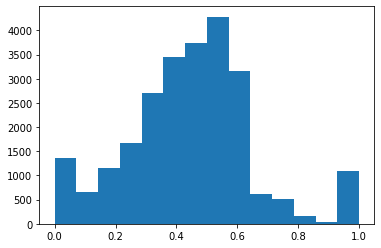

In [7]:
# Inspect data
def inspectData(allSteps):
    print("Total steps:", len(allSteps))
    allValues = [step.value for step in allSteps]
    plt.hist(allValues, bins=14)

    print("Median value:", median(allValues)) # 0.2857 = 4/14, 0.4286 = 6/14

inspectData(allSteps)

## Define Models

In [118]:
# Define a slice of convolution + batch norm
class ConvBN(nn.Module):
    """
    Convolution + batch norm.
    Note that CoreML conversion can't actually take same padding atm.
    Workaround:  Pass in an actual int.
    """
    def __init__(self, inChannels, outChannels, kernelSize, padding="same"):
        super(ConvBN, self).__init__()
        self.conv = nn.Conv2d(in_channels=inChannels,
                              out_channels=outChannels,
                              kernel_size=kernelSize,
                              padding=padding)
        self.norm = nn.BatchNorm2d(num_features=outChannels)

    def forward(self, x):
        return self.norm(self.conv(x))


# Define a residual block that is just two ConvBNs
class ResidualBlock(nn.Module):
    def __init__(self, featureCount, kernelSize):
        super(ResidualBlock, self).__init__()
        padding = (kernelSize - 1) // 2
        self.layer1 = ConvBN(featureCount, featureCount, kernelSize, padding)
        self.layer2 = ConvBN(featureCount, featureCount, kernelSize, padding)

    def forward(self, x):
        return self.layer2(self.layer1(x))

In [120]:
class DrillModel(nn.Module):
    def __init__(self, blockCount):
        super(DrillModel, self).__init__()
        kernelSize = 3
        padding = 1
        featureCount = 43
        convWidth = 32
        valueDenseWidth = 32

        self.initialConv = ConvBN(featureCount, convWidth, kernelSize, padding)
        self.residualBlocks = nn.ModuleList([
            ResidualBlock(convWidth, kernelSize)
            for _ in range(blockCount)
        ])

        self.policyConv1 = ConvBN(convWidth, convWidth, kernelSize, padding)
        self.policyConv2 = ConvBN(convWidth, 8, kernelSize, padding)

        self.valueConv = ConvBN(convWidth, 1, 1, 0)
        self.flatten = nn.Flatten()
        self.valueLinear1 = nn.Linear(10 * 20, valueDenseWidth)
        self.valueLinear2 = nn.Linear(valueDenseWidth, 1)

    def forward(self, x):
        common = F.relu(self.initialConv(x))
        for block in self.residualBlocks:
            common = block(common)
        
        # policy head
        logits = F.relu(self.policyConv1(common))
        logits = self.policyConv2(logits)

        # value head
        value = F.relu(self.valueConv(common))
        value = self.flatten(value)
        value = self.valueLinear1(value)
        value = torch.sigmoid(self.valueLinear2(value))

        return (value, logits)

To go between model trained on CPU/GPU to the other:
[Saving and loading models across devices in pytorch](https://pytorch.org/tutorials/recipes/recipes/save_load_across_devices.html)

## Parsing Datasets

In [116]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [114]:
# I, J, L, O, S, T, Z
# 0, 1, 2, 3, 4, 5, 6
flippedTetromino = [0, 2, 1, 3, 6, 5, 4]
# up, right, down, left
flippedOrientation = [0, 3, 2, 1]

class DataEntry:
    """
    A specification of what a data entry is, that can be unpacked into
    appropriate sample & label.
    """
    def __init__(self, step, addLines=0, removeLines=0, flip=False):
        self.step = step
        self.addLines = addLines
        self.removeLines = removeLines
        self.flip = flip
        # self.previewCount = previewCount

    def parsedSample(self) -> np.ndarray:
        """
        Construct the sample input from a step.  Returns an ndarray of shape
        43 x 20 x 10
        The 43 layers are: the field, and 6 play pieces each with 7 cases.
        """
        field = np.array(self.step.fieldCells).astype('float32')
        tetrominos = self.step.tetrominos[:6]

        # Add solid lines, though not legal game-wise
        if self.addLines:
            field = np.pad(field, (self.addLines * 10, 0), constant_values=1)

        # Remove lines
        if self.removeLines:
            field = np.array(field[self.removeLines * 10:])

        ## Flip
        if self.flip:
            field.shape = (len(field) // 10, 10)
            field = np.flip(field, axis=1).flatten()
            tetrominos = [flippedTetromino[t] for t in tetrominos]

        # Assemble
        field.resize(1 + 6 * 7, 20, 10)
        for (index, value) in enumerate(tetrominos):
            field[1 + index * 7 + value] = 1
        return field

    def parsedLabel(self) -> (float, int):
        """
        Construct the output labels from a step, i.e. value and best action.
        Note that the best action is to be compared (cross entropy) with a
        prior, which is of shape (4 + 4) x 20 x 10, where the first dimension
        represents the 4 rotations of each of the two pieces in play.  The best
        action would be its linear index in the prior.
        """
        value = np.float32(self.step.value)
        bestAction = self.step.actions[0]

        bestAction += 10 * self.addLines
        bestAction -= 10 * self.removeLines

        if self.flip:   # oops... need to unpack and put back together
            pieceOrder = bestAction // 800
            orientation = (bestAction % 800) // 200
            y = (bestAction % 200) // 10
            x = bestAction % 10

            orientation = flippedOrientation[orientation]
            x = 9 - x
            bestAction = 800 * pieceOrder + 200 * orientation + y * 10 + x

        return value, bestAction

In [115]:
# entry = DataEntry(allSteps[8734], addLines=0,removeLines=1, flip=True)
# sample = entry.parsedSample()
# label = entry.parsedLabel()
# label

In [ ]:
# Inexact check of garbage rows (player-made rows can have same shape too)
# print(allSteps[0].fieldCells[10:20].count(True))
# print(allSteps[0].fieldCells[70:80].count(True))
# print(allSteps[0].fieldCells[80:90].count(True))
# print(allSteps[0].fieldCells[150:160].count(True))

In [ ]:
# Imagine composing variants could look like this
# previewVariants = [6]
# reducedRowVariants = [0, 1, 2]
# flippedVariants = [True, False]
# for previews in previewVariants:
#     for reducedRows in reducedRowVariants:
#         for isFlipped in flippedVariants:
#             print((0, 0, previews, reducedRows, isFlipped))

In [125]:
# Create DataSet to wrap the data

class DrillDataset(Dataset):
    def __init__(self, steps):
        entries = []
        for step in steps:
            entry = DataEntry(step, addLines=0, removeLines=0, flip=False)
            entries.append(entry)
        self.entries = entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, index):
        entry = self.entries[index]
        sample = torch.from_numpy(entry.parsedSample()).to(device)
        value, bestAction = entry.parsedLabel()
        value = torch.tensor(value, dtype=torch.float32).to(device)
        bestAction = torch.tensor(bestAction, dtype=torch.long).to(device)
        return sample, (value, bestAction)


## Training

In [121]:
# Initiate model, or load one
# TODO: save/load to drive
model = DrillModel(blockCount=4).to(device)

modelFileName = "drillModel.pth"
# model.load_state_dict(torch.load(modelFileName))
# model.load_state_dict(torch.load(modelFileName, map_location=torch.device('cpu'))())
# model.train()
# model.eval()

In [122]:
# try running a single sample through the model
# sample = torch.from_numpy(sampleFromStep(allSteps[0])).unsqueeze(0)

# prediction = model(sample)
# print(prediction[0])
# print(prediction[1].shape)

In [123]:
# Create a dataset and data loader
# batchSize = 64
# trainDataset = DrillDataset(allSteps)
# trainDataLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)

In [126]:
# Create dataset and split into train & test data loaders

batchSize = 64
allDataset = DrillDataset(allSteps)

trainSize = int(len(allDataset) * 0.8)
testSize = len(allDataset) - trainSize

trainDataset, testDataset = random_split(allDataset, [trainSize, testSize])
trainDataLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)

In [127]:
# Define the loss function
# which will be the sum of these two
# (todo: think about weighting and alternatives)
policyCriterion = nn.CrossEntropyLoss()
valueCriterion = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9,
                            weight_decay=1e-4)

In [128]:
# try the criterions
inputs, labels = next(iter(trainDataLoader))
# inputs = inputs.to(device)
# labels = labels.to(device)
values, policies = model(inputs)
# valueCriterion(values.squeeze(), labels[0])
# policyCriterion(policies.flatten(1), torch.argmax(labels[1].flatten(1), 1))
policyCriterion(policies.flatten(1), labels[1])
# labels[1].squeeze().shape
# policies.squeeze().squeeze().shape
# torch.argmax(labels[1].flatten(1), 1)
# labels[0], values


tensor(7.9130, grad_fn=<NllLossBackward>)

### Training sequence

To do:

- Loss visualization
- Separate validation or testing data
- See if we get to a point where training loss is decreasing but validation loss doesn't
    - Can I overfit?
- Showing some sample outputs
- Automatic saving for long training

- Move some of the prediction-shaping into the model or the data loader, make the training loop cleaner


- In the future, might simplify the saved game records by tossing the full search result priors -- I didn't realize in training only the top result is considered.  This might make the record files drastically smaller.

In [130]:
printFrequency = 20
for epoch in range(1):  # loop over the dataset multiple times

    runningPolicyLoss = 0.0
    runningValueLoss = 0.0

    for i, data in enumerate(trainDataLoader):
        inputs, labels = data
        optimizer.zero_grad()

        values, policies = model(inputs)
        valueLoss = valueCriterion(values.squeeze(), labels[0].to(device))
        policyLoss = policyCriterion(policies.flatten(1), labels[1])
        loss = 50 * valueLoss + policyLoss
        loss.backward()
        optimizer.step()

        # print statistics
        runningValueLoss += valueLoss.item()
        runningPolicyLoss += policyLoss.item()
        if i % printFrequency == printFrequency - 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f, %.5f' %
                  (epoch + 1, i + 1, runningPolicyLoss / printFrequency,
                   runningValueLoss / printFrequency))
            runningPolicyLoss = 0.0
            runningValueLoss = 0.0

print('Finished Training')

[1,    20] loss: 2.705, 0.03547
[1,    40] loss: 2.586, 0.03983
[1,    60] loss: 2.555, 0.03587
[1,    80] loss: 2.631, 0.03605
[1,   100] loss: 2.616, 0.03438
[1,   120] loss: 2.562, 0.03679
[1,   140] loss: 2.406, 0.03761
[1,   160] loss: 2.449, 0.03702
[1,   180] loss: 2.486, 0.03728
[1,   200] loss: 2.418, 0.03911
[1,   220] loss: 2.366, 0.03545
[1,   240] loss: 2.329, 0.03664
[1,   260] loss: 2.353, 0.03360
[1,   280] loss: 2.307, 0.03273
[1,   300] loss: 2.373, 0.03567
Finished Training


In [ ]:
# Save model
# modelFileName = "drillModel-2.pth"
# torch.save(model.state_dict, modelFileName)


## Export

- Need: metadata descriptions for the model (esp. want proper names for policy and value in the output names)


In [ ]:
# Export to CoreML

# model = DrillModel(4)

model.eval()
sample = torch.from_numpy(sampleFromStep(allSteps[0])).unsqueeze(0)
tracedModel = torch.jit.trace(model, sample)
mlmodel = ct.convert(
    tracedModel,
    inputs=[ct.TensorType(name="input", shape=sample.shape)],
    convert_to="mlprogram"
)
mlmodel

Running MIL Clean up passes: 100%|██████████| 8/8 [00:00<00:00, 117.07 passes/s]
/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/backend/mil/passes/sanitize_name_strings.py:75: UserWarning: Output, '186', of the source model, has been renamed to 'var_186' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/backend/mil/passes/sanitize_name_strings.py:75: UserWarning: Output, '205', of the source model, has been renamed to 'var_205' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))


input {
  name: "input"
  type {
    multiArrayType {
      shape: 1
      shape: 43
      shape: 20
      shape: 10
      dataType: FLOAT32
    }
  }
}
output {
  name: "var_205"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
output {
  name: "var_186"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "torch==1.9.0+cu102"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "5.0b3"
  }
}

In [ ]:
mlmodel.save("DrillModelCoreML.mlpackage")

In [ ]:
!zip -r DrillModelProgram DrillModelCoreML.mlpackage/

  adding: DrillModelCoreML.mlpackage/ (stored 0%)
  adding: DrillModelCoreML.mlpackage/Manifest.json (deflated 60%)
  adding: DrillModelCoreML.mlpackage/Data/ (stored 0%)
  adding: DrillModelCoreML.mlpackage/Data/com.apple.CoreML/ (stored 0%)
  adding: DrillModelCoreML.mlpackage/Data/com.apple.CoreML/weights/ (stored 0%)
  adding: DrillModelCoreML.mlpackage/Data/com.apple.CoreML/weights/weight.bin (deflated 7%)
  adding: DrillModelCoreML.mlpackage/Data/com.apple.CoreML/model.mlmodel (deflated 84%)


In [ ]:

## Debugging


# model = TestModel(5, 3, 3, 1)
# model = ResidualBlock(5, 3)
model = ConvBN(5, 5, 3, 1)
# model = DrillModel(4)
exampleInput = torch.rand(1, 5, 20, 10)
tracedModel = torch.jit.trace(model, exampleInput)
mlmodel = ct.convert(
    tracedModel,
    inputs=[ct.TensorType(shape=exampleInput.shape)]
)
mlmodel
# model(exampleInput).shape



In [ ]:
mlmodel = ct.convert(
    tracedModel,
    inputs=[ct.TensorType(shape=sample.shape)])

Converting Frontend ==> MIL Ops:  40%|████      | 4/10 [00:00<00:00, 3056.52 ops/s]


RuntimeError: ignored

In [ ]:
import torch
import torchvision

# Load a pre-trained version of MobileNetV2
torch_model = torchvision.models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
torch_model.eval()

In [ ]:
# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)

In [ ]:
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="input_1", shape=example_input.shape)] #name "input_1" is used in 'quickstart'
)

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 495/495 [00:00<00:00, 822.70 ops/s] 
